In [1]:
import sys

"""
Because I have not realised this package. To use this package, one can not simply install with pip.
Instead, one needs to clone from the repo and append the path to this repo to the system path variable.
"""
sys.path.append('C:/Users/hyli93/Documents/GitHub/Phasing/')

# Import some other necessary packages
import numpy as np
import matplotlib.pyplot as plt
import PhaseTool   # This is the name of this package
import copy

# Create a smooth object

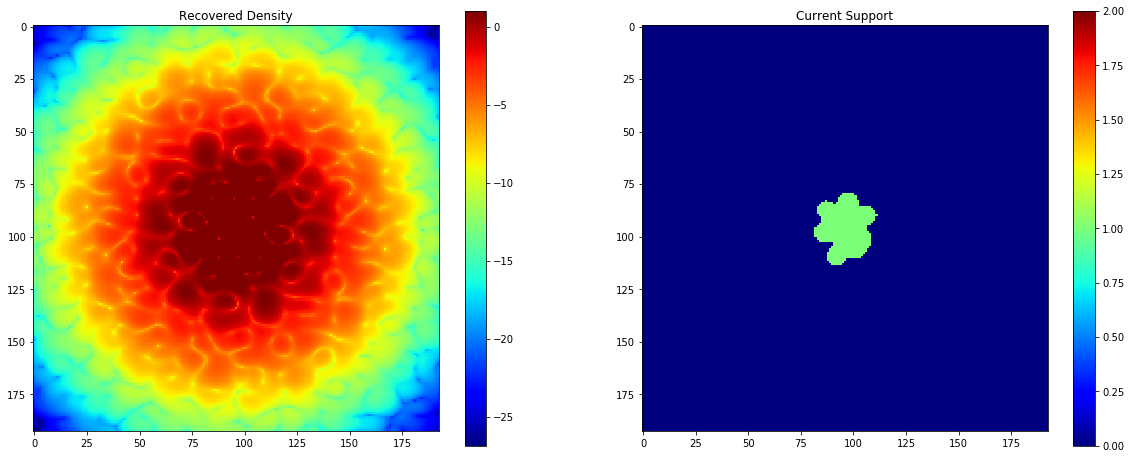

In [2]:
sample = np.sqrt(np.load('./diffCaff48.npy'))

tmp = np.load("./suppCaff48.npy")
support = np.ones_like(tmp,dtype=np.bool)
support[tmp<=0.5] = False


fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(8)
fig.set_figwidth(20)

im = axes[0].imshow(np.log(sample), vmax=1, cmap='jet')
fig.colorbar(im, ax=axes[0])
axes[0].set_title("Recovered Density")

im = axes[1].imshow(support, vmax=2, cmap='jet')
fig.colorbar(im, ax=axes[1])
axes[1].set_title("Current Support")

# Show the canvas
plt.show()  

# Test Step 1: Try some RAAR

In [9]:
# Step 1: Create a object
alter_proj = PhaseTool.AlterProj.CpuAlterProj(prtf_flag=True)

# Step 2: Initialize the object with the data
alter_proj.initialize_easy(magnitude=sample,
                           magnitude_mask=np.ones_like(sample,dtype=np.bool),
                           full_initialization=False)

# Step 3: Set initial guess
alter_proj.set_support(support=np.fft.ifftshift(support))

alter_proj.derive_initial_density(fill_detector_gap=True, method="Random")
    

    
alter_proj.set_algorithm(alg_name="RAAR")
alter_proj.set_beta_and_iter_num(beta=0.90,
                                 iter_num=500,
                                 decay=True, 
                                 decay_rate=30)


The center of the diffraction is :
[96.5 96.5]
There is no gap on the detector. Use the original magnitude.
The user uses a constant value for the beta value. This valuesbeta = 0.9
This values is recognized as the initial beta value for a list of decaying beta values. The length of this list is the iter_num valuewhich is 500


In [10]:
# Step 4: Execute the algorithm of RAAR with 200 Iterations:
alter_proj.execute_algorithm()

# Save to history
alter_proj_hist=[copy.deepcopy(alter_proj),]

Using algorithm RAAR
Finishes self-consistency check.


# Visualization Section

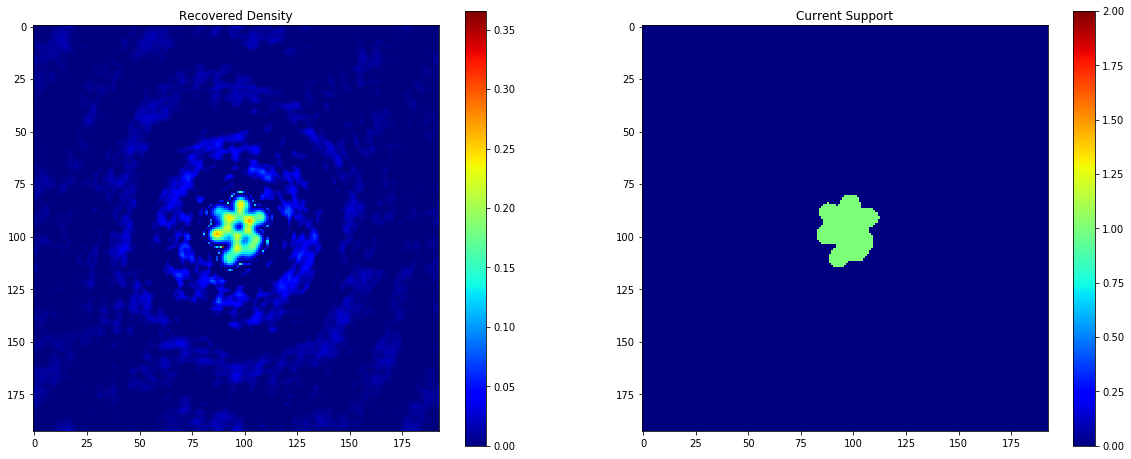

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(8)
fig.set_figwidth(20)

im = axes[0].imshow(np.fft.ifftshift(alter_proj.data_dict['density']), vmin=0, cmap='jet')
fig.colorbar(im, ax=axes[0])
axes[0].set_title("Recovered Density")

im = axes[1].imshow(np.abs(np.fft.ifftshift(alter_proj.data_dict['support'])), vmax=2, cmap='jet')
fig.colorbar(im, ax=axes[1])
axes[1].set_title("Current Support")

# Show the canvas
plt.show()  

# Try some ER

In [12]:
# Copy from history
alter_proj = copy.deepcopy(alter_proj_hist[-1])

alter_proj.set_algorithm(alg_name="ER")

alter_proj.set_beta_and_iter_num(iter_num=1000)

Since the argument beta is not specified, the arguments decay and decay_rate are ignored.


In [13]:
alter_proj.execute_algorithm()

# Save to history
alter_proj_hist.append(copy.deepcopy(alter_proj))

Using algorithm ER
Finishes self-consistency check.


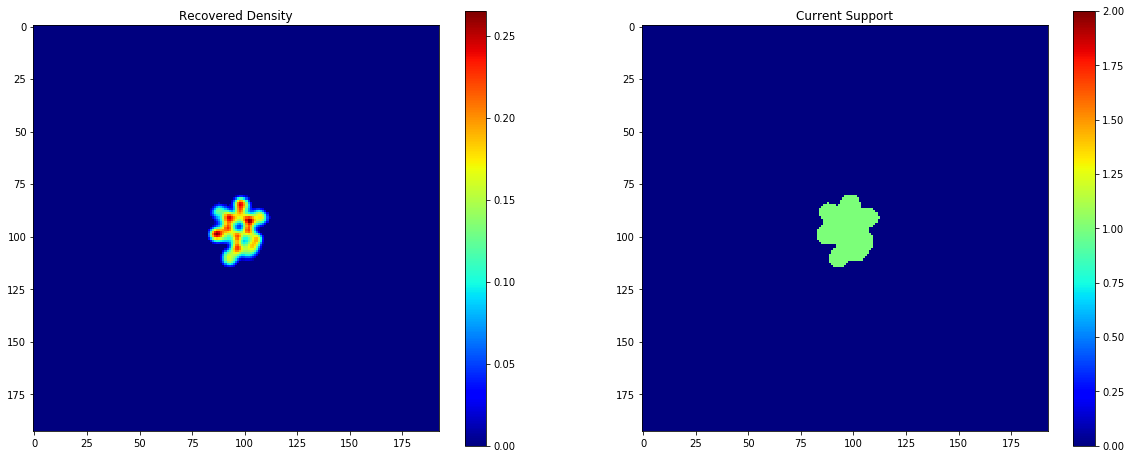

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(8)
fig.set_figwidth(20)

im = axes[0].imshow(np.fft.ifftshift(alter_proj.data_dict['density']), cmap='jet')
fig.colorbar(im, ax=axes[0])
axes[0].set_title("Recovered Density")

im = axes[1].imshow(np.abs(np.fft.ifftshift(alter_proj.data_dict['support'])), vmax=2, cmap='jet')
fig.colorbar(im, ax=axes[1])
axes[1].set_title("Current Support")

# Show the canvas
plt.show()  

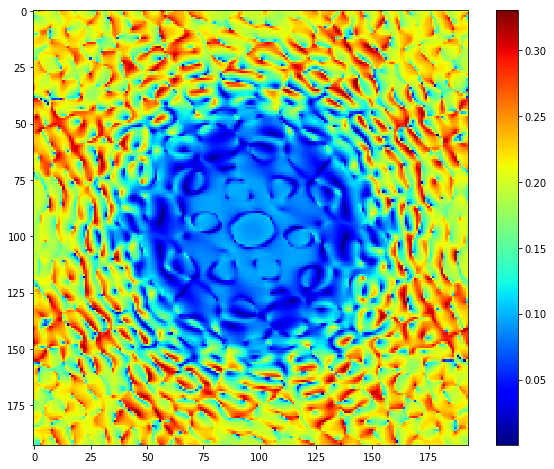

In [19]:
fig = plt.figure(figsize=(10, 8))

plt.imshow(np.abs(np.fft.ifftshift(alter_proj.prtf_array)),cmap='jet')
plt.colorbar()
plt.show()

In [25]:
def get_category_map(value_pattern, bin_num):
    """
    This is a simple function to calculate a category map for the


    :param value_pattern:
    :param bin_num:
    :return:
    """

    value_bins = np.linspace(np.min(value_pattern) * 0.9, np.max(value_pattern) * 1.1,
                             num=bin_num + 1, endpoint=True)
    ends = np.zeros((bin_num, 2), dtype=np.float64)
    ends[:, 0] = value_bins[:-1]
    ends[:, 1] = value_bins[1:]

    category_map = np.ones_like(value_pattern, dtype=np.int64) * bin_num

    for l in range(bin_num):
        category_map[(value_pattern > ends[l, 0]) & (value_pattern <= ends[l, 1])] = l

    return category_map, ends


def get_radial_info(pattern, pattern_mask, origin, bin_num=300):
    """
    This function will be used to provide values to fill those gaps in the detector when
    the user would like to use the auto-correlation as the initial support.

    :param pattern:
    :param pattern_mask
    :param origin:
    :param bin_num:
    :return:
    """
    dim = len(pattern.shape)
    shape = pattern.shape

    if dim != origin.shape[0]:
        raise Exception("The length of the origin array has to be the same as the dimension number"
                        "of the pattern array. i.e. len(pattern.shape)==origin.shape[0]")

    # Calculate the distance regardless of the
    distance = sum(np.meshgrid(*[np.square(np.arange(shape[x]) - origin[x]) for x in range(dim)]))
    np.sqrt(distance, out=distance)

    catmap, ends = get_category_map(value_pattern=distance, bin_num=bin_num)

    # Add the mask info to the catmap variable. Because one would not want to calculate
    # The average including the gaps.
    catmap_masked = np.copy(catmap)
    catmap_masked[np.logical_not(pattern_mask)] = bin_num

    # Get the region where there are some valid pixels.
    cat_start = np.min(catmap_masked)
    cat_stop = np.max(catmap_masked)

    # Get the mean value
    mean_holder = np.zeros(bin_num, dtype=np.float64)
    for l in range(cat_start, cat_stop):
        mean_holder[l] = np.mean(pattern[catmap == l], dtype=np.complex64)

    # Set the lower region values to the same as the
    mean_holder[:cat_start] = mean_holder[cat_start]

    return catmap, mean_holder, ends, distance

In [26]:
prtf_array= np.fft.ifftshift(alter_proj.prtf_array)

radial = get_radial_info(bin_num=90, origin=np.array([96.5,96.5]), pattern= prtf_array,
                                       pattern_mask = np.ones_like(prtf_array, dtype=np.bool))

C:\Users\hyli93\Miniconda3\envs\py3gpu\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


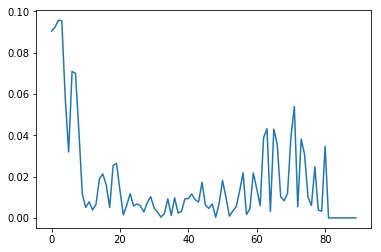

In [28]:
plt.plot(np.abs(radial[1]))
plt.show()